# Part 1 - The network of retweets

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import os
import glob
import community

## Exercise 1

**Exercise 1: Build the network of retweets. We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets.**

In [2]:
#Read data file
df = pd.read_csv('./tweet_names.csv', encoding ='utf-8')

In [3]:
#Create graph
G = nx.DiGraph()

path = './tweets_2019/*'
#Construct graph by going through the twitter files
for filename in glob.glob(path):
    m = filename[14:]
    #Extract twitter name from data file
    tweet_name = df.loc[df['WikiPageName']==m]['tw_name'].item()
    #Extract party from data file
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()
    #Add node to graph
    G.add_node(tweet_name, party=party_name)
    
    #Find all retweets in twitter file
    f = io.open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore').read()
    retweets = re.findall(r'RT @\w*', f)
    for r in set(retweets):
        count = retweets.count(r)
        #Extract twitter name (excluding @RT)
        r = r[4:]
        #Only include edge if the retweet is from a member and if it is not a self loop
        if r in df['tw_name'].values:
            if r!=tweet_name:
                G.add_node(r, party=df.loc[df['tw_name']==r]['Party'].item())
                G.add_edge(tweet_name, r, weight=count)
            

## Exercise 2
**Visualize the network of retweets and investigate differences between the parties.**

**Visualize the network using the Networkx draw function, and nodes coordinates from the force atlas algorithm. Hint: use an undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements. Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the node-size to be proportional to total degree.**

In [4]:
#Crete undirected version for plotting
u_G = G.to_undirected()
#Extract the giant component
Gc = max(nx.connected_component_subgraphs(u_G), key=len)

forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  
                          linLogMode=False, 
                          adjustSizes=False,  
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False, 

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)


In [5]:
#Split nodes into democratics and republicans
dem_nodes = [n for (n,party) in nx.get_node_attributes(Gc,'party').items() if party == 'Democratic']
rep_nodes = [n for (n,party) in nx.get_node_attributes(Gc,'party').items() if party == 'Republican']
#Create list of degrees
d = dict(Gc.degree)
dem_degrees = [(d[node]) * 5 for node in dem_nodes]
rep_degrees = [(d[node]) * 5 for node in rep_nodes]

#Create positions
positions = forceatlas2.forceatlas2_networkx_layout(Gc, pos=None, iterations=5000)

100%|██████████| 5000/5000 [00:22<00:00, 357.22it/s]

BarnesHut Approximation  took  5.64  seconds
Repulsion forces  took  14.30  seconds
Gravitational forces  took  0.21  seconds
Attraction forces  took  0.19  seconds
AdjustSpeedAndApplyForces step  took  0.90  seconds


/Users/marita/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


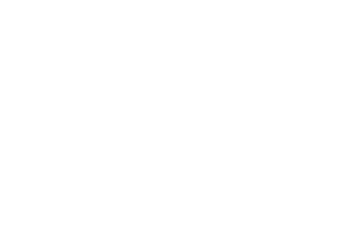

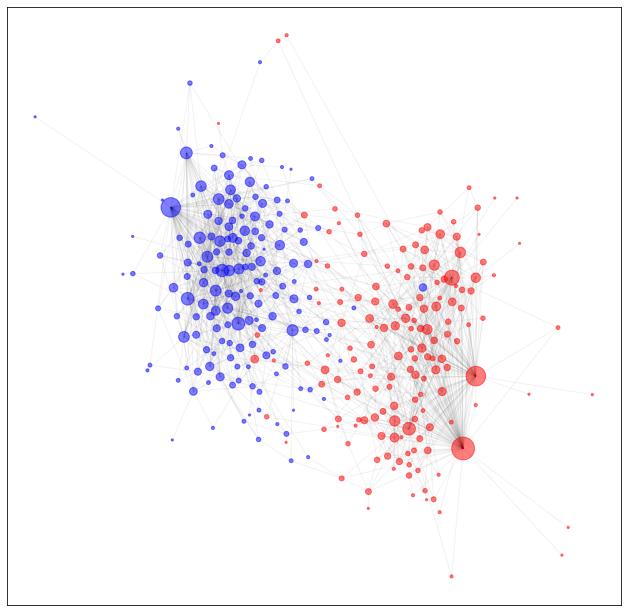

In [6]:
#Plot network where node size is proportional to degrees
plt.axis('off')
plt.figure(figsize=(11,11)) 
nx.draw_networkx_nodes(Gc, positions, nodelist=dem_nodes,node_color='blue', node_size= dem_degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_nodes(Gc, positions, nodelist=rep_nodes,node_color='red', node_size= rep_degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(Gc, positions, alpha=0.05)

plt.show()

**Compare the network of Retweets with the network of Wikipedia pages (generated during Week 5). Do you observe any differences? How do you explain them?**

Network of wikipedia pages shown below. 

<img src="network_part_5.png" alt="wiki_network" style="width:550px;"/>

It can be seen that the new network of retweets looks much more structured than that of the wikipedia pages as the parties are more separeted. This shows that politicians are much more likely to retweet content from within their own party than of the other party (which is no surprise). In the wikipedia network the edges are built from the links and one page might very well link to pages of the other party for a number of reasons.

**Now set the node-size tob proportional to betweenness centrality. Do you observe any changes?**

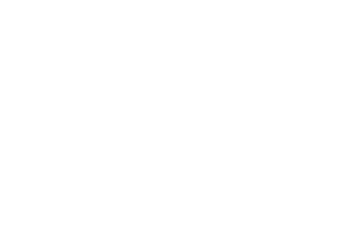

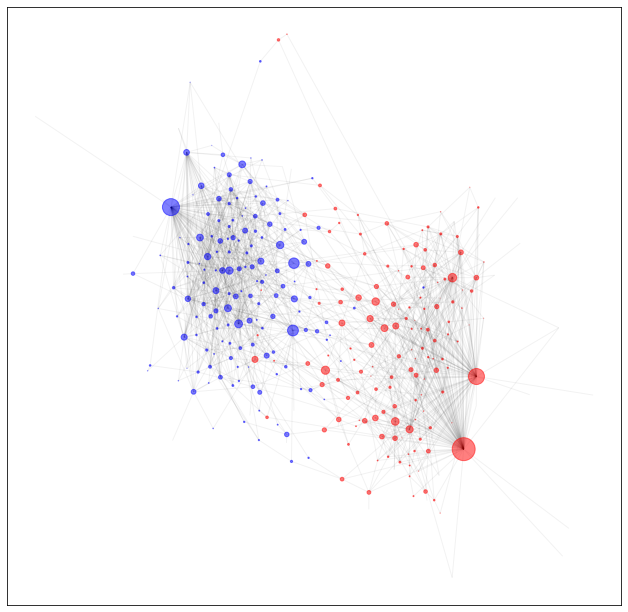

In [11]:
#Calculate the betweeness crentrality
betweeness_centrality = nx.betweenness_centrality(Gc)
dem_betweeness_centrality = [(betweeness_centrality[node]) * 2000 for node in dem_nodes]
rep_betweeness_centrality = [(betweeness_centrality[node]) * 2000 for node in rep_nodes]

#Plot network where node size is proportional to crentrality betweeness
plt.axis('off')
plt.figure(figsize=(11,11)) 
nx.draw_networkx_nodes(Gc, positions, nodelist=dem_nodes,node_color='blue', node_size= dem_betweeness_centrality, with_labels=False, alpha=0.5)
nx.draw_networkx_nodes(Gc, positions, nodelist=rep_nodes,node_color='red', node_size= rep_betweeness_centrality, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(Gc, positions, alpha=0.05)
plt.show()

Betweeness centrality indicates how many shortest paths go through a node. When setting the node size proportional to the betweeness centrality it can be observes that the same nodes are dominating the network, but there is a larger gap between the size of the larger nodes and the smaller nodes. 

**Repeat the point above using eigenvector centrality. Again, do you see a difference? Can you explain why based on what eigenvector centrality measures?**

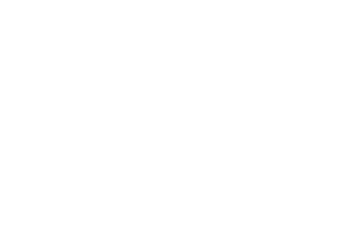

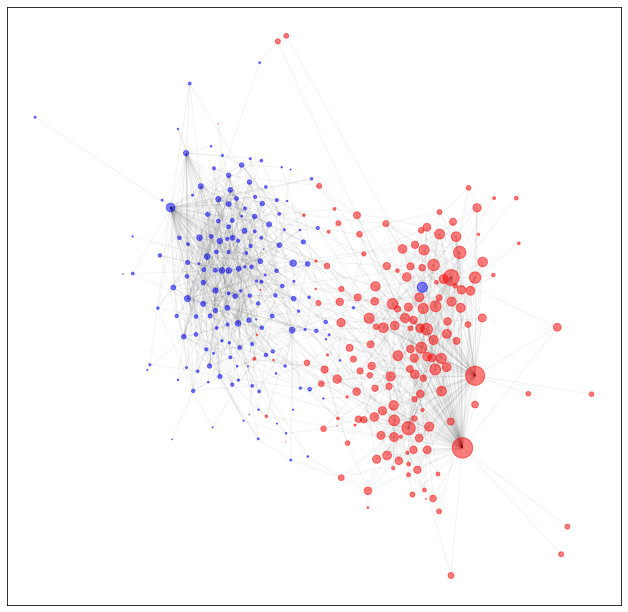

In [13]:
#Calculate eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(Gc,max_iter=500)
dem_eigenvector_centrality = [(eigenvector_centrality[node]) * 1000 for node in dem_nodes]
rep_eigenvector_centrality = [(eigenvector_centrality[node]) * 1000 for node in rep_nodes]

#Plot network where node size is proportional to eigenvector centrality
plt.axis('off')
plt.figure(figsize=(11,11)) 
nx.draw_networkx_nodes(Gc, positions, nodelist=dem_nodes,node_color='blue', node_size= dem_eigenvector_centrality, with_labels=False, alpha=0.5)
nx.draw_networkx_nodes(Gc, positions, nodelist=rep_nodes,node_color='red', node_size= rep_eigenvector_centrality, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(Gc, positions, alpha=0.05)
plt.show()

Here it can be observed that the democratic nodes are generally larger than the republic nodes. The eigenvector centrality measures the centrality of a node based on the centrality of its neighbours. If a node is connected to many nodes that have a high eigenvector centrality then that node will have high eigenvector centrality. This is an indicator of the influence a node has on the network. 

Looking at the network of betweeness centrality it can be seen that there are multiple larger nodes that are connected among the democratic nodes while this is not as clear with the republic nodes. Because of this there are more nodes in among the democratics with a high eigenvector centrality and more the republic nodes have a lower eigenvector centrality.

**Who are the three nodes with highest degree within each party? And wbat is their eigenvector centrality? And their betweenness centrality?**

In [14]:
def getDegree(n):
    return d[n];

#Sort nodes based on degree
dem_nodes.sort(key=getDegree, reverse=True)
rep_nodes.sort(key=getDegree, reverse=True)

#Print nodes with highest degree
print('Democratic nodes with highest degree:', dem_nodes[0:3])
print('Their betweeness centrality:\n', [x + ': '+ str(betweeness_centrality[x]) for x in dem_nodes[0:3]])
print('Their eigenvector centrality:\n', [x + ': '+ str(eigenvector_centrality[x]) for x in dem_nodes[0:3]])
print('\nRepublic nodes with highest degree:', rep_nodes[0:3])
print('Their betweeness centrality:\n', [x + ': '+ str(betweeness_centrality[x]) for x in rep_nodes[0:3]])
print('Their eigenvector centrality:\n', [x + ': '+ str(eigenvector_centrality[x]) for x in rep_nodes[0:3]])

Democratic nodes with highest degree: ['SpeakerPelosi', 'RepLindaSanchez', 'RepRaulGrijalva']
Their betweeness centrality:
 ['SpeakerPelosi: 0.14524953393910742', 'RepLindaSanchez: 0.031288659414405146', 'RepRaulGrijalva: 0.014704717521401208']
Their eigenvector centrality:
 ['SpeakerPelosi: 0.0737011214682027', 'RepLindaSanchez: 0.031249456367512158', 'RepRaulGrijalva: 0.03589881474811744']

Republic nodes with highest degree: ['GOPLeader', 'SteveScalise', 'RepAndyBiggsAZ']
Their betweeness centrality:
 ['GOPLeader: 0.2636434059926712', 'SteveScalise: 0.12885617478177203', 'RepAndyBiggsAZ: 0.035782991684398635']
Their eigenvector centrality:
 ['GOPLeader: 0.4195496153568054', 'SteveScalise: 0.36478930739152793', 'RepAndyBiggsAZ: 0.2500263634813289']


**Plot (on the same figure) the distribution of outgoing strength for the republican and democratic nodes repectively (i.e. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?**

In [15]:
total_retweets = {'Republican': 0, 'Democratic': 0}
#for each file count retweets (this could be done in the same loop that was used to build the network, but was 
#done here to make it easier to see what part of the assignment this belongs to)
for filename in glob.glob(path):
    m = filename[14:]
    tweet_name = df.loc[df['WikiPageName']==m]['tw_name'].item()
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()
    
    f = io.open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore').read()
    retweets = re.findall(r'RT @\w*', f)
    for r in set(retweets):
        r = r[4:]
        #Increment counter if the tweet comes from a member but not a the member himself
        if r in df['tw_name'].values:
            if r!=tweet_name:
                total_retweets[party_name] +=1
    

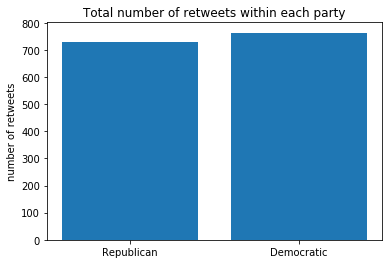

In [43]:
#Plot the number of retweets as a barplot
plt.bar(range(len(total_retweets)), list(total_retweets.values()), align='center')
plt.title("Total number of retweets within each party")
plt.ylabel("number of retweets")
plt.xticks(range(len(total_retweets)), list(total_retweets.keys()))
plt.show()

It can be seen on the plot that the democratic retweet more than the republic party.

**Find the 3 members of the republican party that have retweeted tweets from democratic members most often. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?**

In [17]:
retweets_from_other_party = {'Republican': {}, 'Democratic': {}}
#for each file count retweets from the other party (as in the previous question, 
#this could have combined with the other loops)
for filename in glob.glob(path):
    m = filename[14:]
    tweet_name = df.loc[df['WikiPageName']==m]['tw_name'].item()
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()
    retweets_from_other_party[party_name][tweet_name] = 0
    
    f = io.open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore').read()
    retweets = re.findall(r'RT @\w*', f)
    for r in set(retweets):
        r = r[4:]
        if r in df['tw_name'].values:
            other_party = df.loc[df['tw_name']==r]['Party'].item()
            #Only count retweet if the party of the two members is different
            if party_name != other_party:
                retweets_from_other_party[party_name][tweet_name] +=1
                
#Sort members based on number of retweets from the other party and print the highest
rep_list = sorted(retweets_from_other_party['Republican'], key=retweets_from_other_party['Republican'].get, reverse=True)
rep_name_list = [df.loc[df['tw_name']==x]['WikiPageName'].item() for x in rep_list]
print('Republicans that retweeted democratics most:', rep_name_list[0:3])
dem_list = sorted(retweets_from_other_party['Democratic'], key=retweets_from_other_party['Democratic'].get, reverse=True)
dem_name_list = [df.loc[df['tw_name']==x]['WikiPageName'].item() for x in dem_list]
print('Democratics that retweeted republicans most:', dem_name_list[0:3])

Republicans that retweeted democratics most: ['Brian_Fitzpatrick_(American_politician)', 'Jim_Sensenbrenner', 'Tom_Reed_(politician)']
Democratics that retweeted republicans most: ['Gene_Green', 'Ted_Deutch', 'Cedric_Richmond']


Brian Fitzpatrick was ranked the third most bipartisan member of the House of Representatives. I'm not sure how to explain it for the other ones.

## Exercise 3: Community detection
**Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network (Week 7)? Comment on your result.**

In [18]:
partition = community.best_partition(Gc)
print('Modularity:', community.modularity(partition, Gc))


Modularity: 0.4845738251041047


Modularity in wikipedia network: 0.6263424609787711

The modularity is higher in the wikipedia network. Higher modularity means that a larger fraction of the edges are within communities compared to between nodes of different communities. Since the modularity of the wikipedia network is higher, this indicates that the communities of that network are stronger than that of the twitter network. This might be because when one wikipedia page links other wikipedia pages these are likely to link to each other too, as links often occur because these members did something together or were all part of something and all of these pages will mention this 'something' and thus have the same links.

**Visualize the network, using the Force Atlas algorithm. This time assign each node a different color based on their community. Describe the structure you observe.**

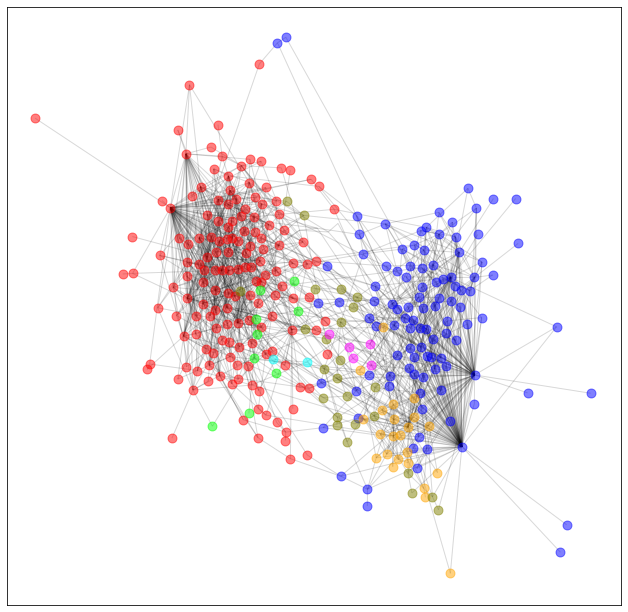

In [35]:
plt.figure(figsize=(11,11)) 


p0= list(dict(filter(lambda x: x[1] == 0, partition.items())).keys())
p1= list(dict(filter(lambda x: x[1] == 1, partition.items())).keys())
p2= list(dict(filter(lambda x: x[1] == 2, partition.items())).keys())
p3= list(dict(filter(lambda x: x[1] == 3, partition.items())).keys())
p4= list(dict(filter(lambda x: x[1] == 4, partition.items())).keys())
p5= list(dict(filter(lambda x: x[1] == 5, partition.items())).keys())
p6= list(dict(filter(lambda x: x[1] == 6, partition.items())).keys())

communities = [p0,p1,p2,p3,p4,p5,p6]
colours = ['red', 'lime', 'blue', 'orange', 'olive', 'magenta', 'Aqua']

for i,com in enumerate(communities, start=0):
    nx.draw_networkx_nodes(Gc, positions, nodelist=com,node_color=colours[i], node_size= 80, with_labels=False, alpha=0.5)

nx.draw_networkx_edges(Gc, positions, alpha=0.05)
nx.draw_networkx_edges(Gc,positions, alpha=0.1)
plt.show()

It can be observed that the largets communities are those of the party. But there is one community among the republican nodes and a few community that are more of a mix of the two parties. 

**Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.**

In [40]:

parties = [dem_nodes, rep_nodes]

B=2
C=len(set(partition.values()))
confusion_matrix=np.zeros( (B, C-1) )

for i,party in enumerate(parties, start=0):
    for j, com in enumerate(communities, start=0):
        confusion_matrix[i][j] = len(list(set(party).intersection(com)))



print('Confusion matrix:\n',confusion_matrix)
    

Confusion matrix:
 [[144.   6.   1.   0.   7.   1.   0.]
 [  7.   3. 103.  23.  18.   4.   2.]]


**Use the confusion matrix to explain how well the communities you've detected correspond to the parties. Consider the following questions**

- **Are there any republicans grouped with democrats (and vice versa)?**

There are two main communities that mainly consist of members within a single party. There are three very small communities that have fewer than 10 members, two are a mix between the parties and one consists only of two republicans. Then there is one slightly larger community (25 members) that is a mix between the two parties.

- **Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.**

The republican party has a small community within itself that only consists of republicans. It might be the tea party that we observe as this sub community. 